In [1]:
%matplotlib inline

In [2]:
from datetime import datetime
import os
from os.path import dirname, abspath, join
from os import getcwd
import sys

In [3]:
import random
import string
import pandas as pd
import numpy as np

In [4]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [6]:
import torch
import socket
from IPython.display import clear_output

In [7]:
import itertools
import multiprocessing as mp

In [8]:
# seed_arg = int(sys.argv[1])
# print ("\n\nSeed ARG: ",seed_arg)
seed_arg = 0

In [9]:
seedlist = np.array([161, 314, 228, 271828, 230, 4271031, 5526538, 6610165, 9849252, 34534, 73422, 8765])
seed = seedlist[seed_arg]
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [10]:
class ENO(object):
    
    #no. of forecast types is 6 ranging from 0 to 5
  
    def __init__(self, location='tokyo', year=2010, shuffle=False, day_balance=False):
        self.location = location
        self.year = year
        self.day = None
        self.hr = None
        
        self.shuffle = shuffle
        self.day_balance = day_balance

        self.TIME_STEPS = None #no. of time steps in one episode
        self.NO_OF_DAYS = None #no. of days in one year
        
        self.NO_OF_DAYTYPE = 10 #no. of daytypes
        self.daycounter = 0 #to count number of days that have been passed
        
        self.sradiation = None #matrix with GSR for the entire year
        self.senergy = None #matrix with harvested energy data for the entire year
        self.fforecast = None #array with forecast values for each day
        

        self.henergy = None #harvested energy variable
        self.fcast = None #forecast variable
        self.sorted_days = [] #days sorted according to day type
        
        self.SMAX = 1000 # 1 Watt Solar Panel

    
    #function to get the solar data for the given location and year and prep it
    def get_data(self):
        #solar_data/CSV files contain the values of GSR (Global Solar Radiation in MegaJoules per meters squared per hour)
        #weather_data/CSV files contain the weather summary from 06:00 to 18:00 and 18:00 to 06:00+1
        location = self.location
        year = self.year

        THIS_DIR = getcwd()
        SDATA_DIR = abspath(join(THIS_DIR, 'solar_data'))  #abspath(join(THIS_DIR, '../../..', 'data'))
        
        sfile = SDATA_DIR + '/' + location +'/' + str(year) + '.csv'
        
        #skiprows=4 to remove unnecessary title texts
        #usecols=4 to read only the Global Solar Radiation (GSR) values
        solar_radiation = pd.read_csv(sfile, skiprows=4, encoding='shift_jisx0213', usecols=[4])
      
        #convert dataframe to numpy array
        solar_radiation = solar_radiation.values

        #convert missing data in CSV files to zero
        solar_radiation[np.isnan(solar_radiation)] = 0

        #reshape solar_radiation into no_of_daysx24 array
        solar_radiation = solar_radiation.reshape(-1,24)

        if(self.shuffle): #if class instatiation calls for shuffling the day order. Required when learning
            np.random.shuffle(solar_radiation) 
        self.sradiation = solar_radiation
        
        #GSR values (in MJ/sq.mts per hour) need to be expressed in mW
        # Conversion is accomplished by 
        # solar_energy = GSR(in MJ/m2/hr) * 1e6 * size of solar cell * efficiency of solar cell /(60x60) *1000 (to express in mW)
        # the factor of 2 in the end is assuming two solar cells
        self.senergy = 2*self.sradiation * 1e6 * (55e-3 * 70e-3) * 0.15 * 1000/(60*60)

        return 0
    
    #function to map total day radiation into type of day ranging from 0 to 5
    #the classification into day types is quite arbitrary. There is no solid logic behind this type of classification.
    
    def get_day_state(self,tot_day_radiation):
        bin_edges = np.array([0, 3.5, 6.5, 9.0, 12.5, 15.5, 18.5, 22.0, 25, 28])
        for k in np.arange(1,bin_edges.size):
            if (bin_edges[k-1] <= tot_day_radiation <= bin_edges[k]):
                day_state = k -1
                break
            else:
                day_state = bin_edges.size - 1
        return int(day_state)
    
    def get_forecast(self):
        #create a perfect forecaster.
        tot_day_radiation = np.sum(self.sradiation, axis=1) #contains total solar radiation for each day
        get_day_state = np.vectorize(self.get_day_state)
        self.fforecast = get_day_state(tot_day_radiation)
        
        #sort days depending on the type of day and shuffle them; maybe required when learning
        for fcast in range(0,6):
            fcast_days = ([i for i,x in enumerate(self.fforecast) if x == fcast])
            np.random.shuffle(fcast_days)
            self.sorted_days.append(fcast_days)
        return 0
    
    def reset(self,day=0): #it is possible to reset to the beginning of a certain day
        
        self.get_data() #first get data for the given year
        self.get_forecast() #calculate the forecast
        
        self.TIME_STEPS = self.senergy.shape[1]
        self.NO_OF_DAYS = self.senergy.shape[0]
        
        self.day = day
        self.hr = 0
        
        self.henergy = self.senergy[self.day][self.hr]
        self.fcast = self.fforecast[self.day]
        
        end_of_day = False
        end_of_year = False
        return [self.henergy, self.fcast, end_of_day, end_of_year]

    
    def step(self):
        end_of_day = False
        end_of_year = False
        if not(self.day_balance): #if daytype balance is not required
            if(self.hr < self.TIME_STEPS - 1):
                self.hr += 1
                self.henergy = self.senergy[self.day][self.hr] 
                self.fcast = self.fforecast[self.day]
            else:
                if(self.day < self.NO_OF_DAYS -1):
                    end_of_day = True
                    self.hr = 0
                    self.day += 1
                    self.henergy = self.senergy[self.day][self.hr] 
                    self.fcast = self.fforecast[self.day]
                else:
                    end_of_day = True
                    end_of_year = True

                    
        else: #when training, we want all daytypes to be equally represented for robust policy
              #obviously, the days are going to be in random order
            if(self.hr < self.TIME_STEPS - 1):
                self.hr += 1
                self.henergy = self.senergy[self.day][self.hr]
                self.fcast = self.fforecast[self.day]
            else:
                if(self.daycounter < self.NO_OF_DAYS -1):
                    end_of_day = True
                    self.daycounter += 1
                    self.hr = 0
                    daytype = random.choice(np.arange(0,self.NO_OF_DAYTYPE)) #choose random daytype
                    self.day = np.random.choice(self.sorted_days[daytype]) #choose random day from that daytype
                    self.henergy = self.senergy[self.day][self.hr] 
                    self.fcast = self.fforecast[self.day]
                else: 
                    end_of_day = True
                    end_of_year = True
                    self.daycounter = 0
        
        return [self.henergy, self.fcast, end_of_day, end_of_year]

In [11]:
class CAPM (object):
    def __init__(self,location='tokyo', year=2010, shuffle=False, trainmode=False):

        #all energy values i.e. BMIN, BMAX, BOPT, HMAX are in mWhr. Assuming one timestep is one hour
        
        self.BMIN = 50.0                #Minimum battery level that is tolerated. Maybe non-zero also
        self.BMAX = 10000.0            #Max Battery Level. May not necessarily be equal to total batter capacity [3.6V x 2500mAh]
        self.BOPT = 0.5 * self.BMAX    #Optimal Battery Level. Assuming 50% of battery is the optimum
        self.BLIM_LO = 0.15*self.BMAX
        self.BLIM_HI = 0.85*self.BMAX
        self.BSAFE_LO = 0.35*self.BMAX
        self.BSAFE_HI = 0.65*self.BMAX
        
        self.ENP_MARGIN = 0.3*self.BMAX

        
        self.HMIN = 0      #Minimum energy that can be harvested by the solar panel.
        self.HMAX = None   #Maximum energy that can be harvested by the solar panel. [500mW]
        
        self.DMAX = 500      #Maximum energy that can be consumed by the node in one time step. [~ 3.6V x 135mA]
        self.N_ACTIONS = 10  #No. of different duty cycles possible
        self.DMIN = self.DMAX/self.N_ACTIONS #Minimum energy that can be consumed by the node in one time step. [~ 3.6V x 15mA]
        
        self.binit = None     #battery at the beginning of day
        self.btrack = []      #track the battery level for each day
        self.v_btrack = []      #track the virtual battery level for each day

        self.atrack = []      #track the duty cycles for each day
        self.htrack = []      #track the harvested for each day
        self.batt = None      #battery variable
        self.enp = None       #enp at end of hr
        self.henergy = None   #harvested energy variable
        self.fcast = None     #forecast variable
        
        self.MUBATT = 0.6
        self.SDBATT = 0.02
        
        self.MUHENERGY = 0.5
        self.SDHENERGY = 0.2
        
        self.MUENP = 0
        self.SDENP = 0.02
        
        self.location  = location
        self.year      = year
        self.shuffle   = shuffle
        self.trainmode = trainmode
        self.eno       = None
        
        self.day_violation_flag = False
        self.violation_flag     = False
        self.violation_counter  = 0
        self.batt_full_counter  = 0
        self.batt_empty_counter = 0
        
        self.batt_violations    = 0

        self.NO_OF_DAYTYPE      = 10 #no. of daytypes
 
    def reset(self,day=0,batt=-1):
        henergy, fcast, day_end, year_end = self.eno.reset(day) #reset the eno environment
        self.violation_flag = False
        self.violation_counter = 0
        self.batt_violations = 0
        
        if(batt == -1):
            self.batt = self.BOPT
        else:
            self.batt = batt
            
        self.batt = np.clip(self.batt, self.BMIN, self.BMAX)
        self.binit = self.batt
        self.btrack = np.append(self.btrack, self.batt) #track battery levels
        self.v_btrack = np.append(self.v_btrack, self.batt) #track battery levels
#         self.enp = self.BOPT - self.batt
        self.enp = self.binit - self.batt #enp is calculated
        self.henergy = np.clip(henergy, self.HMIN, self.HMAX) #clip henergy within HMIN and HMAX
        self.fcast = fcast
        
        norm_batt    = self.batt    /self.BMAX
        norm_enp     = self.enp     /self.BMAX
        norm_henergy = self.henergy /self.HMAX
        norm_fcast   = self.fcast   /(self.NO_OF_DAYTYPE-1)
        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states

        reward = 0
        
        return [c_state, reward, day_end, year_end]
    
    def getstate(self): #query the present state of the system
        norm_batt    = self.batt    /self.BMAX
        norm_enp     = self.enp     /self.BMAX
        norm_henergy = self.henergy /self.HMAX
        norm_fcast   = self.fcast   /(self.NO_OF_DAYTYPE-1)
        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states

        return c_state
        
    
    #reward function
    def rewardfn(self):
        violation_penalty = 0
        bmean = np.mean(self.btrack)
        bdev = self.BOPT - bmean
        if np.abs(bdev) > (self.BOPT - self.ENP_MARGIN):
            reward = 1.5-np.abs(bdev)/self.BMAX*5
        else:
            reward = 1
#         reward = 2 - 20*np.abs(bdev)/self.BMAX
#         if(self.day_violation_flag):
#             violation_penalty += 3    #penalty for violating battery limits anytime during the day
        return np.clip(reward,-1,1)#(reward - violation_penalty)
    
    
    
    def step(self, action):
        day_end = False
        year_end = False
        self.violation_flag = False
        reward = 0
        self.atrack = np.append(self.atrack, action+1) #track duty cycles
        self.htrack = np.append(self.htrack, self.henergy)

#         action_var = np.abs(np.mean(self.atrack) - action)/9 #can vary from 0 to 1
#         reward += 0.25*(0.5 - action_var ) #reward penalizing high duty cycle variance [-0.5 to 0.5]*0.25
      
        action = np.clip(action, 0, self.N_ACTIONS-1) #action values range from (0 to N_ACTIONS-1)
        e_consumed = (action+1)*self.DMAX/self.N_ACTIONS   #energy consumed by the node
        
        
        self.batt += (self.henergy - e_consumed)
        
#         v_batt = self.binit + self.htrack.sum() - self.atrack.sum()*self.DMAX/self.N_ACTIONS
#         self.v_btrack = np.append(self.v_btrack, v_batt) #track battery levels
        
        if(self.batt <= self.BMIN or self.batt >= self.BMAX ):
                self.batt_violations += 1
        
        if(self.batt <= self.BMIN or self.batt >= self.BMAX ):
#         if(self.batt < self.BLIM_LO or self.batt > self.BLIM_HI ):
            self.violation_flag = True #penalty for violating battery limits everytime it happens
#             reward -= 2
#             if(self.batt < self.BLIM_LO): #battery depletion is more fatal than battery overflow
#                 reward -= 2

        if(self.batt <= self.BMIN ): 
            self.batt_empty_counter += 1
        if(self.batt >= self.BMAX ): 
            self.batt_full_counter  += 1

        if(self.violation_flag):
            if(self.day_violation_flag == False): #penalty for violating battery limits anytime during the day - triggers once everyday
                self.violation_counter += 1
                self.day_violation_flag = True
                
        #calculate ENP before clipping
#         self.enp = self.BOPT - self.batt
        self.enp = self.binit - self.batt
        
        self.batt = np.clip(self.batt, self.BMIN, self.BMAX) #clip battery values within permitted level
        self.btrack = np.append(self.btrack, self.batt) #track battery levels
        
        
        #proceed to the next time step
       
        self.henergy, self.fcast, day_end, year_end = self.eno.step()
        self.henergy = np.clip(self.henergy, self.HMIN, self.HMAX) #clip henergy within HMIN and HMAX
                        
        if(day_end): #if eno object flags that the day has ended then give reward
            reward += self.rewardfn()
            if (self.trainmode): #reset battery to optimal level if limits are exceeded when training
#                 self.batt = np.random.uniform(self.DMAX*self.eno.TIME_STEPS/self.BMAX,0.8)*self.BMAX
#                 if (self.violation_flag):
                if np.random.uniform() < HELP : #occasionaly reset the battery
                    self.batt = self.BOPT  
            
            self.day_violation_flag = False
            self.binit = self.batt #this will be the new initial battery level for next day
            self.btrack = [] #clear battery tracker
#             self.v_btrack = [] #clear battery tracker
            self.atrack = [] #clear duty cycle tracker
            self.htrack = [] #clear henergy tracker
   
        norm_batt    = self.batt    /self.BMAX
        norm_enp     = self.enp     /self.BMAX
        norm_henergy = self.henergy /self.HMAX
        norm_fcast   = self.fcast   /(self.NO_OF_DAYTYPE-1)
        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states
        
        return [c_state, reward, day_end, year_end]

In [12]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8))# + datetime.now().strftime("_%H_%M_%S")

LOCATION       = 'tokyo'
NAME           = 'DENO'+ RNDM_STRING+ '_'+datetime.now().strftime("_%H_%M_%S")+"_"
MODEL_FILENAME = './models/'+ NAME + '_' + str(seed) + '.pt'
print("\nMODEL : ", MODEL_FILENAME)
print("SEED  : ",seed_arg)
print("HOST  : ",socket.gethostname())
print("START : ",datetime.now())


MODEL :  ./models/DENOSTI6WR1Z__19_08_48__161.pt
SEED  :  0
HOST  :  19c994a59e65
START :  2019-07-02 19:08:48.411226


In [13]:
# Hyper Parameters
BATCH_SIZE          = 32
WT_DECAY            = None
LR                  = 1e-4          # learning rate
EPSILON             = 0.9           # greedy policy
GAMMA               = 0.99           # reward discount
LAMBDA              = 0.95          # parameter decay
TARGET_REPLACE_ITER = 24*7*4*18     # target update frequency
MEMORY_CAPACITY     = 24*7*4*12*3*10   # store upto six month worth of memory   

N_ACTIONS           = 10            # no. of duty cycles (0,1,2,3,4)
N_STATES            = 4             # number of state space parameter [batt, enp, henergy, fcast]

HIDDEN_LAYER        = 50            # width of NN
NN_ITERATIONS       = 10000
GPU                 = False         # device
HELP                = 0.05
print("HYPERPARAMETERS")

HYPERPARAMETERS


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

#Class definitions for NN model and learning algorithm
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class DQN(object):
    def __init__(self):
        if(GPU): 
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        else:
            device = torch.device('cpu')
        self.eval_net, self.target_net = Net(), Net()
        self.eval_net.to(device)
        self.target_net.to(device)
        self.device = device

        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory [mem: ([s], a, r, [s_]) ]
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)

        self.running_loss = 0.0
        
        self.loss_func = nn.MSELoss()
        self.nettoggle = False

    
#     def choose_action(self, x):
#         x = torch.unsqueeze(torch.FloatTensor(x), 0)
#         x = x.to(self.device)

#         actions_value = self.eval_net.forward(x)
#         actions_value = actions_value.to(torch.device("cpu"))
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] # return the argmax index
#         if np.random.uniform() > EPSILON:   # greedy
# #             action += np.random.randint(-3, 3)
# #             action = int(np.clip(action, 0, N_ACTIONS-1))
# #             action = np.random.randint(0,N_ACTIONS)
#             action = np.random.choice(np.arange(0, N_ACTIONS), p=[0.55, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

#         return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        x = x.to(self.device)

        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.to(torch.device("cpu"))
        action = torch.max(actions_value, 1)[1].data.numpy().flatten()
        action = action[0] # return the argmax index
        
        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1
    
    def store_day_transition(self, transition_rec):
        data = transition_rec
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory= np.insert(self.memory, index, data,0)
        self.memory_counter += transition_rec.shape[0]

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
            self.nettoggle = not self.nettoggle
        self.learn_step_counter += 1

        # sample batch transitions
        sample_index_limit = min(MEMORY_CAPACITY, self.memory_counter)
        sample_index = np.random.choice(sample_index_limit, BATCH_SIZE)
#         sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])
        
        b_s = b_s.to(self.device)
        b_a = b_a.to(self.device)
        b_r = b_r.to(self.device)
        b_s_ = b_s_.to(self.device)

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER))
            self.running_loss = 0.0

In [15]:
c_init      = CAPM()
c_init.eno  = ENO()
c_init.HMAX = c_init.eno.SMAX

In [16]:
# CONSTANTS
BMAX = c_init.BMAX
HMAX = c_init.HMAX

In [17]:
#DISCRETIZING LIMITS 

B_MAX = c_init.BMAX
B_MIN = 0

ENP_MAX =  c_init.BMAX
ENP_MIN = -c_init.BMAX

H_MAX =  c_init.HMAX
H_MIN =  0

F_MAX = c_init.NO_OF_DAYTYPE - 1
F_MIN = 0

In [18]:
def normalize(s):
    normalizer = np.array([BMAX, BMAX, HMAX, F_MAX])
    return s/normalizer[None,:]        

In [19]:
def denormalize(s):
    normalizer = np.array([BMAX, BMAX, HMAX, F_MAX])
    return s*normalizer[None,:]    

In [20]:
def stdize(s):
    MU_BATT = 0.5
    SD_BATT = 0.5
    
    MU_ENP = 0
    SD_ENP = 0.5
    
    MU_HENERGY = 0.35
    SD_HENERGY = 0.55
    
    MU_FCAST = 0.5
    SD_FCAST = 0.6
    
    norm_batt, norm_enp, norm_henergy, norm_fcast = s
    
    std_batt    = (norm_batt    - MU_BATT    )/SD_BATT
    std_enp     = (norm_enp     - MU_ENP     )/SD_ENP
    std_henergy = (norm_henergy - MU_HENERGY )/SD_HENERGY
    std_fcast   = (norm_fcast   - MU_FCAST   )/SD_FCAST

    return [std_batt, std_enp, std_henergy, std_fcast]

In [21]:
def batch_stdize(s):
    MU_BATT = 0.5
    SD_BATT = 0.5
    
    MU_ENP = 0
    SD_ENP = 0.5
    
    MU_HENERGY = 0.35
    SD_HENERGY = 0.55
    
    MU_FCAST = 0.5
    SD_FCAST = 0.6
     
    MU = np.array([MU_BATT, MU_ENP, MU_HENERGY, MU_FCAST])
    SD = np.array([SD_BATT, SD_ENP, SD_HENERGY, SD_FCAST])
        
    X = s - MU[None, :]
    return X/SD[None,:]

def batch_destdize(s):
    MU_BATT = 0.5
    SD_BATT = 0.5
    
    MU_ENP = 0
    SD_ENP = 0.5
    
    MU_HENERGY = 0.35
    SD_HENERGY = 0.55
    
    MU_FCAST = 0.5
    SD_FCAST = 0.6
     
    MU = np.array([MU_BATT, MU_ENP, MU_HENERGY, MU_FCAST])
    SD = np.array([SD_BATT, SD_ENP, SD_HENERGY, SD_FCAST])
        
    X = s*SD[None, :]
    return X + MU[None,:]

In [22]:
NO_OF_NODES = 10
LOCATION = 'tokyo'
my_dqn = DQN()

In [23]:
def T_ENO(node_id, day, sc_EPSILON, param_file, capm):
    my_capm = capm
    my_capm.eno.hr = 0
    experience_record = np.empty((my_capm.eno.TIME_STEPS ,N_STATES * 2 + 2))

    my_dqn.eval_net.load_state_dict(torch.load(param_file))
    my_dqn.eval_net.eval()
    np.random.seed(node_id+day)

    my_EPSILON = sc_EPSILON
#     PREF = 1-my_EPSILON

    s = my_capm.getstate()
    

#     my_prob = [(1-PREF)/NO_OF_NODES]*NO_OF_NODES
#     my_prob[int((node_id)%N_ACTIONS)] += PREF
    while True:
        
        if np.random.uniform() > my_EPSILON:
            a = np.random.randint(0,N_ACTIONS)
#             a = np.random.choice(np.arange(0, N_ACTIONS), p=my_prob)
        else:
            a = my_dqn.choose_greedy_action(stdize(s))

        
        # take action
        s_, r, day_end, year_end = my_capm.step(a)

        # store experience   
        experience_record[int(my_capm.eno.hr-1)] = np.hstack((stdize(s), [a, r], stdize(s_)))

        s = s_
        
        if day_end:
            experience_record[:,N_STATES + 1]  = r
            break
            

    
    
    return [experience_record, my_capm]

In [24]:
dqn = DQN()
torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)
dqn.eval_net.eval()
pool = mp.Pool(processes=NO_OF_NODES)

2000
NN_ITER: 10000
DAY: 7
MEMORY:  1920

CHECKING... 


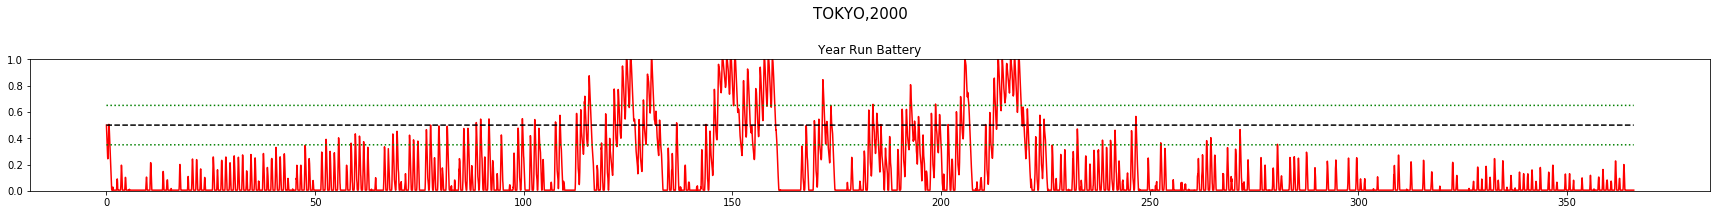

LOSS : 0.230
LOSS : 0.093
LOSS : 0.052
LOSS : 0.045
LOSS : 0.046
LOSS : 0.060
LOSS : 0.085
NN_ITER: 11000
DAY: 14
MEMORY:  3600

CHECKING... 


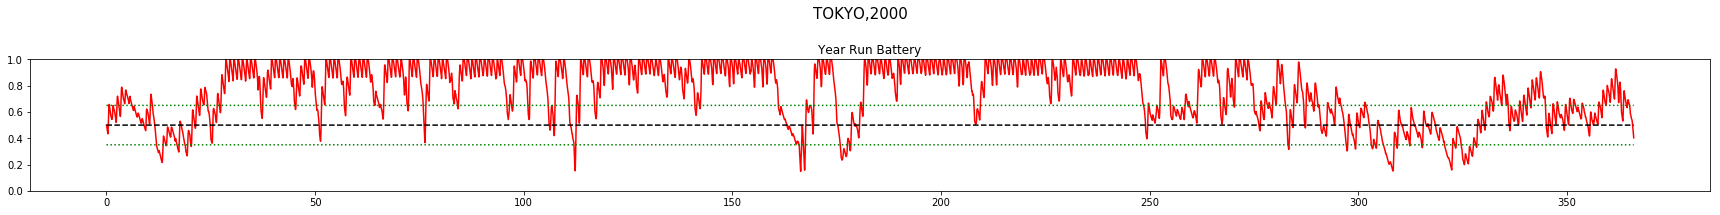

LOSS : 0.115
LOSS : 0.149
LOSS : 0.199
LOSS : 0.277
LOSS : 0.404
LOSS : 0.508
LOSS : 0.696
NN_ITER: 12000
DAY: 21
MEMORY:  5280

CHECKING... 


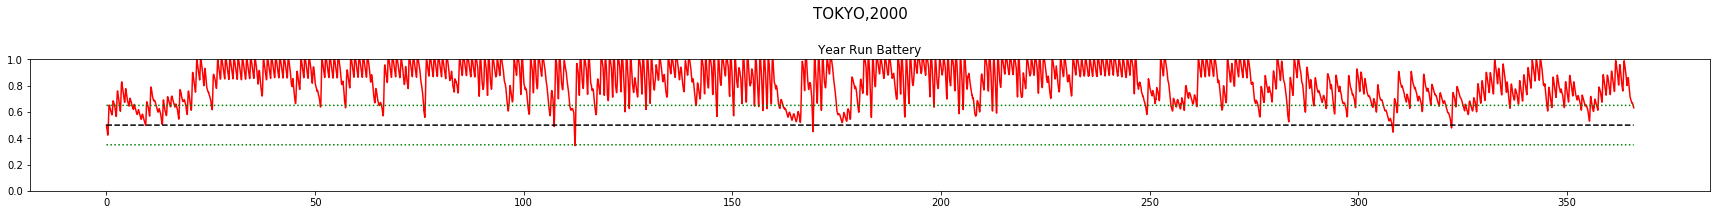

LOSS : 0.992
LOSS : 1.264
LOSS : 1.514
LOSS : 1.713
LOSS : 1.840
LOSS : 1.990
LOSS : 2.239
NN_ITER: 13000
DAY: 28
MEMORY:  6960

CHECKING... 


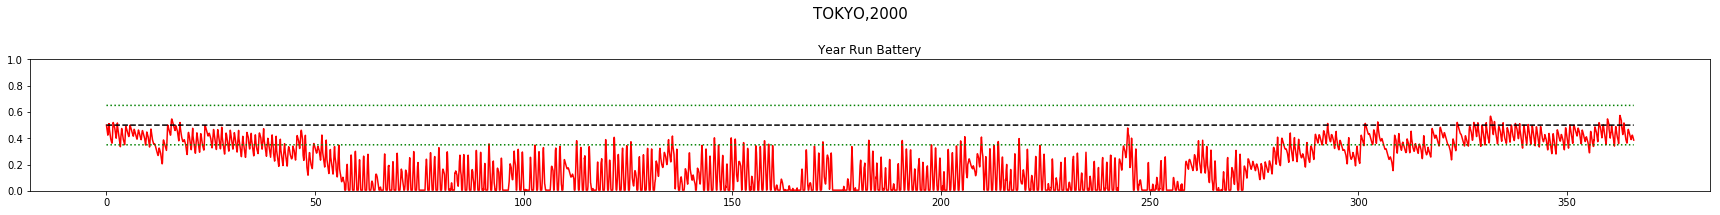

LOSS : 2.175
LOSS : 2.171
LOSS : 2.135
LOSS : 2.019
LOSS : 2.010
LOSS : 2.008
LOSS : 2.035


In [25]:
from figplot import figplot


TOTAL_MEMORY = []

yr = 2000
dummy1 = CAPM(LOCATION, yr)
dummy1.eno = ENO(LOCATION, yr)
dummy1.HMAX = dummy1.eno.SMAX
dummy1.reset()
capm_list = [dummy1]*NO_OF_NODES

for iteration in range(1):
    for cpm in capm_list:
        cpm.year = yr+iteration
        cpm.eno.day = 0
    print(capm_list[0].year)
    for day in range(5*7):
#         print(capm_list[0].year,":",capm_list[0].eno.day)
        if iteration == 0:
            e_slope = 0.1/2
            e_start = 0.1
            sc_EPSILON = np.clip(e_start + e_slope*day,0.5,0.99)

        day_list = [day]*NO_OF_NODES
        sc_EPSILON_list = [sc_EPSILON]*NO_OF_NODES
        param_list = [MODEL_FILENAME]*NO_OF_NODES
        arglist = [arg for arg in zip(range(NO_OF_NODES), day_list, sc_EPSILON_list, param_list, capm_list)]
        result = pool.starmap(T_ENO, arglist)

        node_experience  = np.array([item[0] for item in result])
        capm_list = [item[1] for item in result]

        TOTAL_MEMORY.append(node_experience)
        all_exp = np.array([item for each_node_exp in node_experience 
                                    for episode_exp in each_node_exp 
                                        for item in episode_exp]).reshape(-1,10)

        dqn.memory = np.insert(dqn.memory, 0, all_exp , 0)
        dqn.memory = dqn.memory[:MEMORY_CAPACITY,:]
        dqn.memory_counter += all_exp.shape[0]


        if dqn.memory_counter > 24*7*10:#MEMORY_CAPACITY:
            for nn_iter in range(NN_ITERATIONS):
                dqn.learn()
            #validate by running for TIMESTEP_LIMIT iterations

            if day%7==0:
        #     print("\n*****************************************")
                print("NN_ITER:", NN_ITERATIONS)
                NN_ITERATIONS += 1000
                NN_ITERATIONS = np.clip(NN_ITERATIONS, 100, 15000)
                print("DAY:", day)
    #             print("REWARDS: ", node_reward)
        #     print("EMPTY  : ", node_empty_count)
        #     print("FULL   : ", node_full_count)
        #     print("ID      :",ids)
        # #     print("YEAR    :",yr)
    #             print("EPSILON :",eps)
                print("MEMORY: ",dqn.memory_counter)


                print("\nCHECKING... ")
                # CHECKING NN MODEL
                #########################################################################################################################
                LOCATION = 'tokyo'# random.choice(['tokyo','aomori','fukuoka'])
                YEAR = 2000#random.choice(np.arange(2000,2010))

                capm = CAPM(LOCATION,YEAR,shuffle=False, trainmode=False) #instantiate the CAPM class
                capm.eno = ENO(LOCATION,YEAR, shuffle=False, day_balance=False) #instantiate the environment inside the CAPM class
                capm.HMAX = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object

                s, r, day_end, year_end = capm.reset()
                yr_test_record = np.empty(4)

                while True:
                    a = dqn.choose_greedy_action(stdize(s))
                    #state = [batt, enp, henergy, fcast]
                    yr_test_record = np.vstack((yr_test_record, [s[0],s[2],r, a])) #record battery, henergy, reward and action

                    # take action
                    s_, r, day_end, year_end = capm.step(a)

                    if year_end:
                        break

                    s = s_

                yr_test_record = np.delete(yr_test_record, 0, 0) #remove the first row which is garbage
                yr_test_reward_rec = yr_test_record[:,2]
                yr_test_reward_rec = yr_test_reward_rec[::24]

                title = LOCATION.upper() + ',' + str(YEAR)
                NO_OF_DAYS = capm.eno.NO_OF_DAYS

                fig = plt.figure(figsize=(24,3))
                fig.suptitle(title, fontsize=15)

                #     ax1 = fig.add_subplot(211)
                #     ax1.plot(yr_test_reward_rec)
                #     ax1.set_title("\n\nYear Run Reward")
                #     ax1.set_ylim([-3,3])

                #Plot the reward and battery for the entire year run
                ax2 = fig.add_subplot(111)
                ax2.plot(yr_test_record[:,0],'r')
                ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BOPT/capm.BMAX, 'k--')
    #             ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BLIM_LO/capm.BMAX, 'r:')
    #             ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BLIM_HI/capm.BMAX, 'r:')
                ax2.plot(np.ones_like(yr_test_record[:,0])*(capm.BOPT+capm.ENP_MARGIN /2) /capm.BMAX, 'g:')
                ax2.plot(np.ones_like(yr_test_record[:,0])*(capm.BOPT-capm.ENP_MARGIN/2)/capm.BMAX, 'g:')
                ax2.set_title("\n\nYear Run Battery")
                ax2.set_ylim([0,1])
                plt.sca(ax2)
                plt.xticks(np.arange(0, NO_OF_DAYS*24, 50*24),np.arange(0,NO_OF_DAYS,50))
                fig.tight_layout()
                plt.show()
                ##########################################################################################################################


        # SAVE MODEL
        torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

pool.close()
pool.join()
    
    

In [26]:
TOTAL_MEMORY = np.array(TOTAL_MEMORY)
MEM = np.einsum('dnes->ndes',TOTAL_MEMORY)

#single file all data
STATES = MEM[:,:,:,0:N_STATES].reshape(-1,4)
ACTIONS = MEM[:,:,:,N_STATES:N_STATES+1].reshape(-1,1)
REWARDS = MEM[:,:,:,N_STATES+1:N_STATES+2].reshape(-1,1)

In [27]:
#Destandardize state values from memory
DSTD_STATES = batch_destdize(STATES)

In [28]:
#NODE_MEMS contains list of (s,a,r) for all hours of all days for each node
NODE_MEMS = np.column_stack((DSTD_STATES,ACTIONS,REWARDS))
NODE_MEMS = NODE_MEMS.reshape(NO_OF_NODES,-1,6)

In [29]:
# plt.figure(figsize=(24,3))
# plt.plot(node_0[:,0],'r')
# # plt.plot(z[:,1])
# plt.plot(node_0[:,2],'c',alpha=0.4)
# # plt.plot(node_0[:,3],'b')
# plt.plot(node_0[:,4]/9,'b')
# # plt.plot(node_0[:,5],'k--')
# plt.minorticks_on()

# plt.grid(which='both',axis='x')

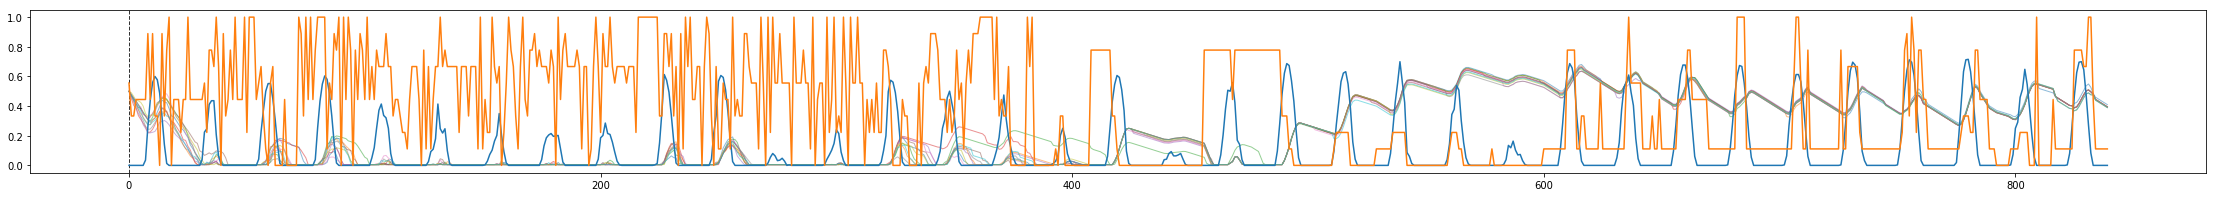

In [30]:
plt.figure(figsize=(39,3))
for i in range(NO_OF_NODES):
    plt.plot(NODE_MEMS[i,:,0], alpha=0.5, linewidth=1.0)
for i in range(iteration+1):
    plt.axvline(x=i*24*365,color='k',linewidth=1.0,linestyle='--',alpha=0.8)

plt.plot(NODE_MEMS[0,:,2])
plt.plot(NODE_MEMS[0,:,4]/9)




In [31]:
batt = NODE_MEMS[:,:,0]

In [32]:
downtime_occur = (batt < 0.006).astype(int)
overflow_occur = (batt == 1).astype(int)

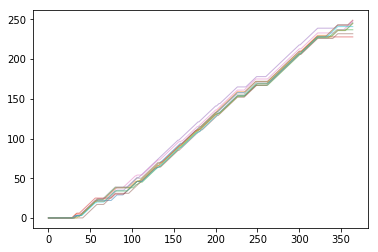

In [33]:
#DOWNTIME PER NODE WITH TIME
for i in range(NO_OF_NODES):
    plt.plot(downtime_occur[i,0:365].cumsum(), alpha=0.5, linewidth=1.0)

# for i in range(iteration+1):
#     plt.axvline(x=i*24*365,color='k',linewidth=1.0,linestyle='--',alpha=0.1)

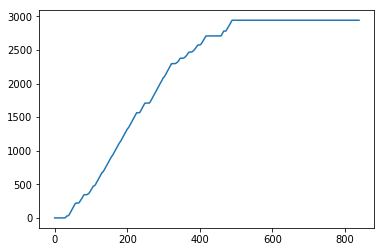

In [34]:
# OVERALL DOWNTIME OF SYSTEM

total_downtime = downtime_occur.sum(axis=0)
plt.plot(total_downtime.cumsum())

# for i in range(iteration+1):
#     plt.axvline(x=i*24*365,color='k',linewidth=1.0,linestyle='--',alpha=0.1)

<BarContainer object of 10 artists>

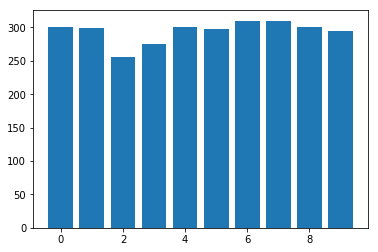

In [35]:
# TOTAL DOWNTIME PER NODE

total_downtime = downtime_occur.sum(axis = 1)
plt.bar(range(NO_OF_NODES),height = total_downtime)

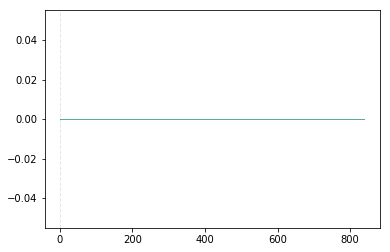

In [36]:
#OVERFLOW PER NODE WITH TIME

for i in range(NO_OF_NODES):
    plt.plot(overflow_occur[i,:].cumsum(), alpha=0.5, linewidth=1.0)
    
for i in range(iteration+1):
    plt.axvline(x=i*24*365,color='k',linewidth=1.0,linestyle='--',alpha=0.1)

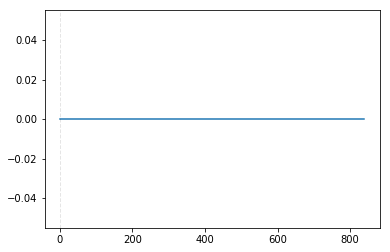

In [37]:
# OVERALL OVERFLOW OF SYSTEM

total_overflow = overflow_occur.sum(axis=0)
plt.plot(total_overflow.cumsum())

for i in range(iteration+1):
    plt.axvline(x=i*24*365,color='k',linewidth=1.0,linestyle='--',alpha=0.1)

<BarContainer object of 10 artists>

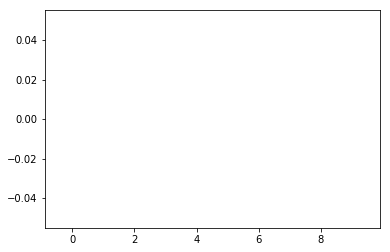

In [38]:
# TOTAL OVERFLOW  PER NODE

total_overflow = overflow_occur.sum(axis = 1)
plt.bar(range(NO_OF_NODES),height = total_overflow)

In [39]:
S_FILENAME = MODEL_FILENAME
print("Loading MODEL from FILE: ", S_FILENAME)
dqn = DQN()
dqn.eval_net.load_state_dict(torch.load(S_FILENAME))
dqn.eval_net.eval()
print("DEVICE: ", dqn.device)

Loading MODEL from FILE:  ./models/DENOSTI6WR1Z__19_08_48__161.pt
DEVICE:  cpu


***MEASURING PERFORMANCE OF THE MODEL***


************************************
Day Violations           =     37
Battery Limit Violations =    702
Battery FULL Violations  =      0
Battery EMPTY Violations =    702


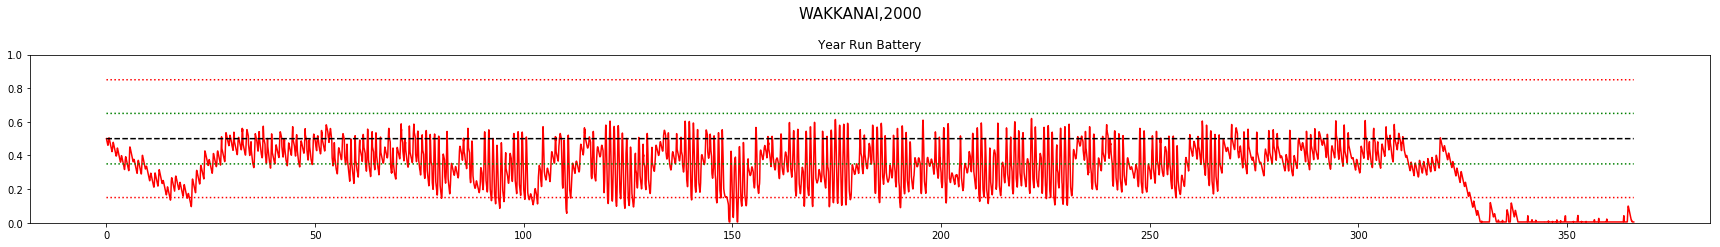



************************************
Day Violations           =     27
Battery Limit Violations =    586
Battery FULL Violations  =      0
Battery EMPTY Violations =    586


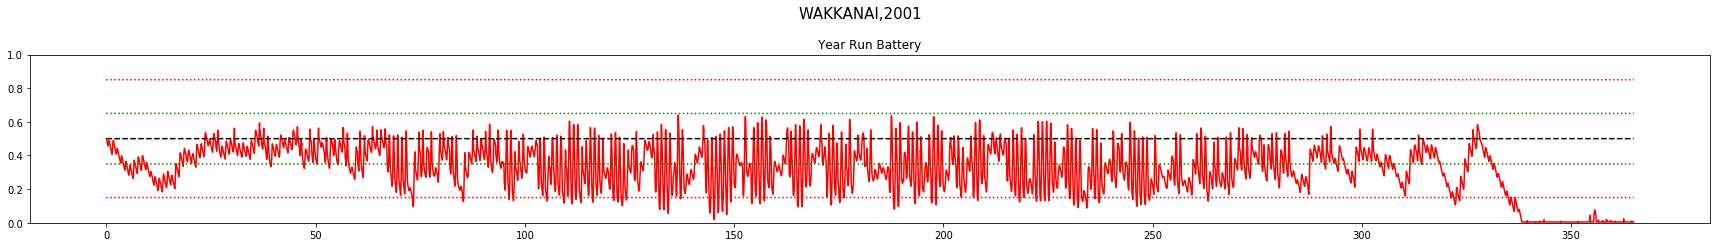



************************************
Day Violations           =     40
Battery Limit Violations =    831
Battery FULL Violations  =      0
Battery EMPTY Violations =    831


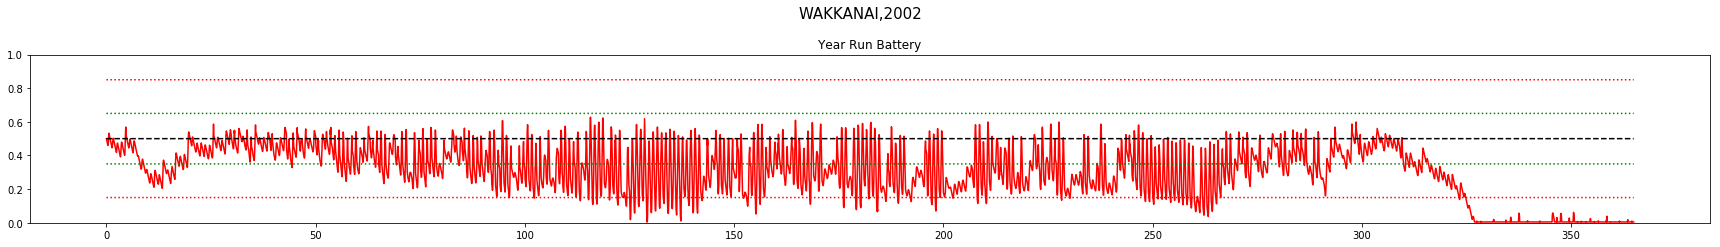



************************************
Day Violations           =     18
Battery Limit Violations =    365
Battery FULL Violations  =      0
Battery EMPTY Violations =    365


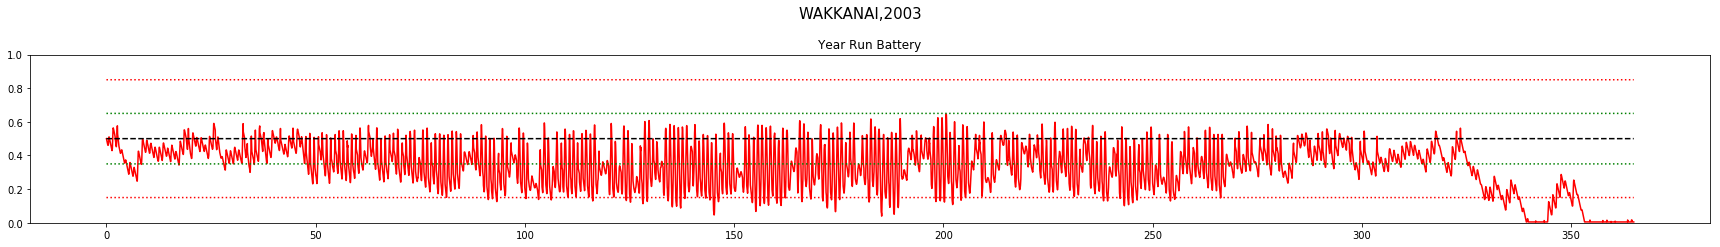



************************************
Day Violations           =     35
Battery Limit Violations =    642
Battery FULL Violations  =      0
Battery EMPTY Violations =    642


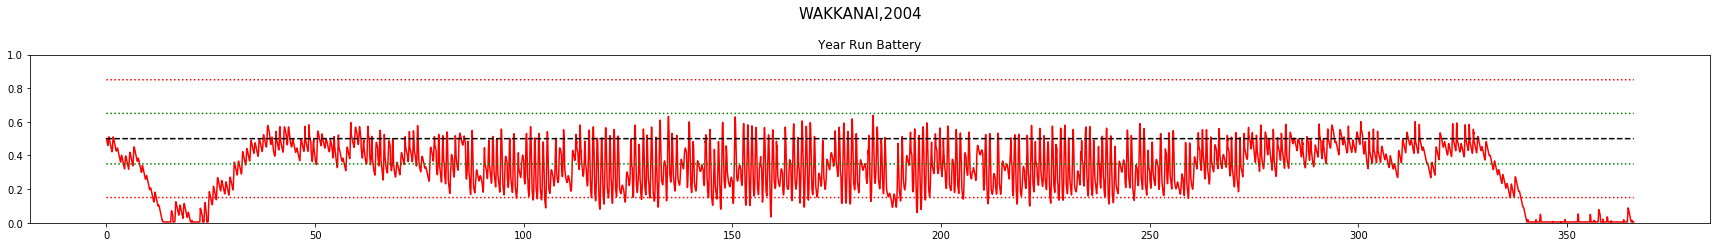



************************************
Day Violations           =     24
Battery Limit Violations =    392
Battery FULL Violations  =      0
Battery EMPTY Violations =    392


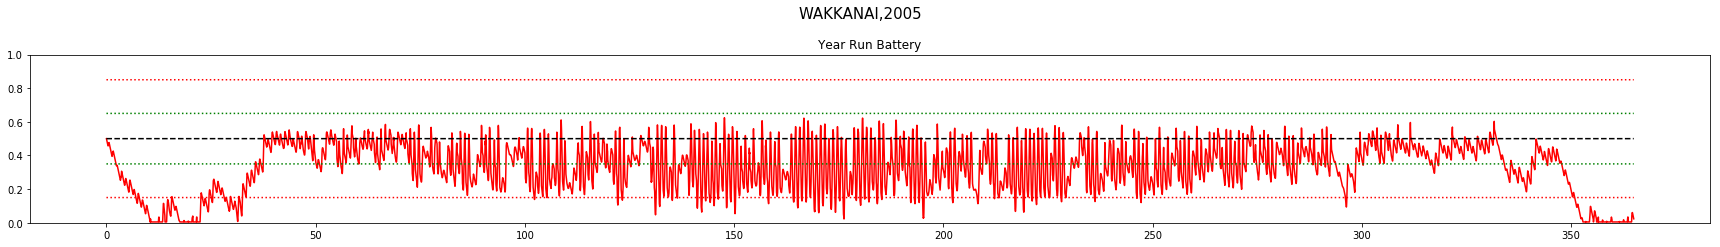



************************************
Day Violations           =     27
Battery Limit Violations =    516
Battery FULL Violations  =      0
Battery EMPTY Violations =    516


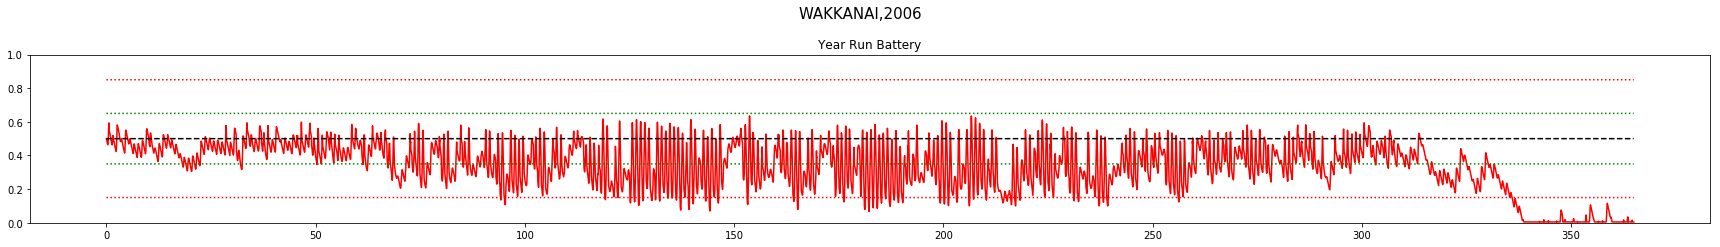



************************************
Day Violations           =     29
Battery Limit Violations =    587
Battery FULL Violations  =      0
Battery EMPTY Violations =    587


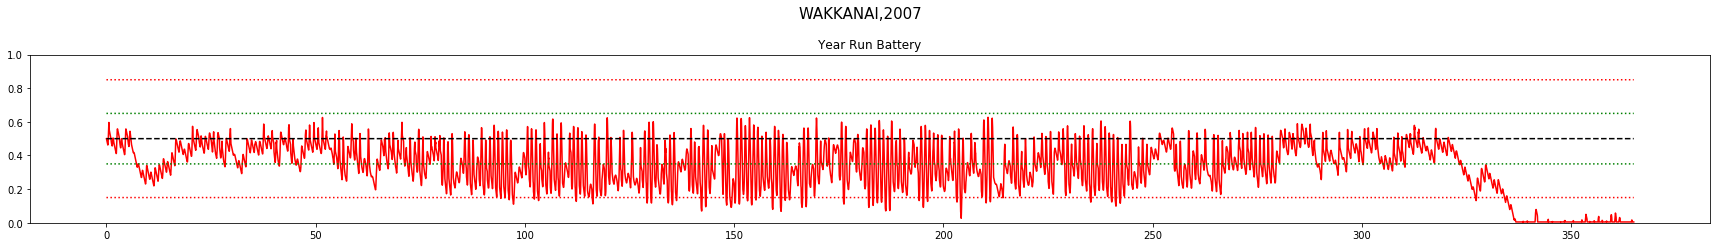



************************************
Day Violations           =     33
Battery Limit Violations =    610
Battery FULL Violations  =      0
Battery EMPTY Violations =    610


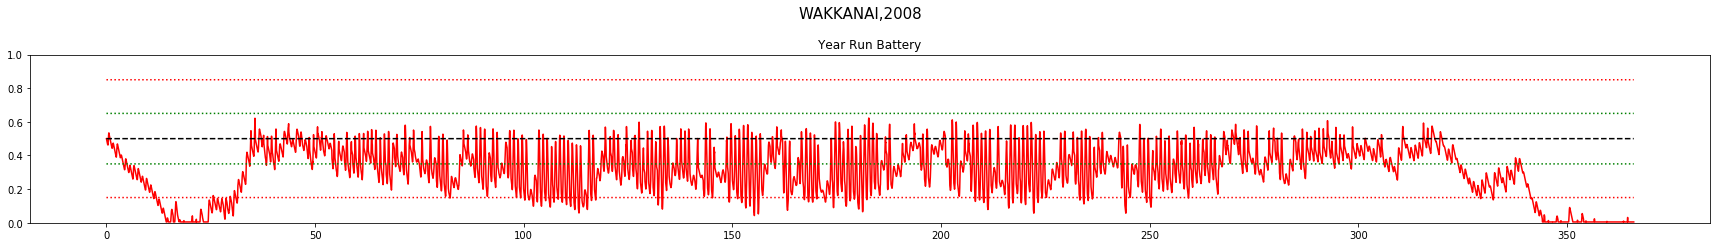



************************************
Day Violations           =     46
Battery Limit Violations =    753
Battery FULL Violations  =      0
Battery EMPTY Violations =    753


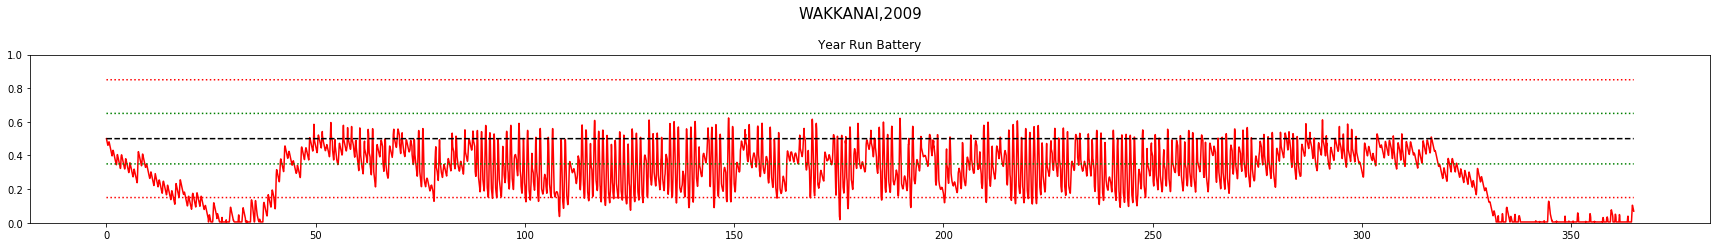



************************************
Day Violations           =     24
Battery Limit Violations =    473
Battery FULL Violations  =      0
Battery EMPTY Violations =    473


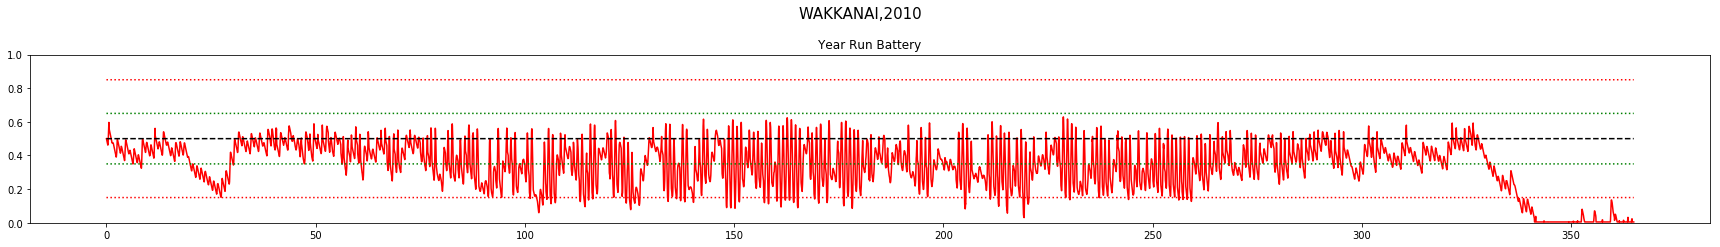

KeyboardInterrupt: 

In [40]:
#VALIDATION PHASE
print("***MEASURING PERFORMANCE OF THE MODEL***")
for LOCATION in ['wakkanai','aomori','tokyo','fukuoka','minamidaito']:
    results = np.empty(6)
    for YEAR in np.arange(2000,2019):
        capm      = CAPM(LOCATION,YEAR,shuffle=False, trainmode=False) #instantiate the CAPM class
        capm.eno  = ENO(LOCATION,YEAR, shuffle=False, day_balance=False) #instantiate the environment inside the CAPM class
        capm.HMAX = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object

        s, r, day_end, year_end = capm.reset()
        yr_test_record = np.empty(4)

        while True:
            a = dqn.choose_greedy_action(stdize(s))
            yr_test_record = np.vstack((yr_test_record, [s[0],s[2],r, a])) #record battery, henergy, reward and action
            s_, r, day_end, year_end = capm.step(a)
            if year_end:
                break
            s = s_

        yr_test_record = np.delete(yr_test_record, 0, 0) #remove the first row which is garbage
        yr_test_reward_rec = yr_test_record[:,2]
        yr_test_reward_rec = yr_test_reward_rec[::24] #annual average reward
        results = np.vstack((results, [int(YEAR), np.mean(yr_test_reward_rec), int(capm.violation_counter), int(capm.batt_violations), int(capm.batt_empty_counter), int(capm.batt_full_counter)]))
        print("\n\n************************************")
        print("Day Violations           = {:6d}".format(capm.violation_counter))
        print("Battery Limit Violations = {:6d}".format(capm.batt_violations))
        print("Battery FULL Violations  = {:6d}".format(capm.batt_full_counter))
        print("Battery EMPTY Violations = {:6d}".format(capm.batt_empty_counter))
    ###########################################################################################
    ###########################################################################################
        #     Plot the reward and battery for the entire year run
        title = LOCATION.upper() + ',' + str(YEAR)
        NO_OF_DAYS = capm.eno.NO_OF_DAYS

        fig = plt.figure(figsize=(24,6))
        fig.suptitle(title, fontsize=15)

    #         ax1 = fig.add_subplot(211)
    #         ax1.plot(yr_test_reward_rec)
    #         ax1.set_title("\n\nYear Run Reward")
    #         ax1.set_ylim([-4,2])

        ax2 = fig.add_subplot(211)
        ax2.plot(yr_test_record[:,0],'r')
        ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BOPT/capm.BMAX, 'k--')
        ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BLIM_LO/capm.BMAX, 'r:')
        ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BLIM_HI/capm.BMAX, 'r:')
        ax2.plot(np.ones_like(yr_test_record[:,0])*(capm.BOPT+capm.ENP_MARGIN /2) /capm.BMAX, 'g:')
        ax2.plot(np.ones_like(yr_test_record[:,0])*(capm.BOPT-capm.ENP_MARGIN/2)/capm.BMAX, 'g:')

        ax2.set_title("\n\nYear Run Battery")
        ax2.set_ylim([0,1])
        plt.sca(ax2)
        plt.xticks(np.arange(0, NO_OF_DAYS*24, 50*24),np.arange(0,NO_OF_DAYS,50))
        fig.tight_layout()
        plt.show()
    ###########################################################################################
    ###########################################################################################


    results = np.delete(results,0,0)
    print("\n")
    print(LOCATION.upper())
    print('YEAR\tAVG_RWD\t\tVIOLATIONS\tEMPTY\tFULL')
    print('\t\t\tDAY\tBATT')

    for x in np.arange(0,results.shape[0]):
        print('{}\t {}\t\t{}\t {}\t{}\t{}'.format(int(results[x,0]), np.around(results[x,1],2), int(results[x,2]), int(results[x,3]), int(results[x,4]),  int(results[x,5]) ))

    print("\nTOTAL Day  Violations:  ",np.sum(results[:, 2]))
    print("TOTAL Batt  Violations: ",np.sum(results[:,3]))
    print("TOTAL EMPTY Violations: ",np.sum(results[:,4]))
    print("TOTAL FULL  Violations: ",np.sum(results[:,5]))
    print("************************************")